# Distributed Computing Final Assignment
### Bahaar Khalilian and Hesam Mohebi

### We first start by setting up PySpark. This is done by starting a Spark Session. We name this application "E-commerce session 1".

## Adding dependencies

In [ ]:
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, sum, count, year, month, first, to_date, min, max, lit, datediff
)
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd


## Q1: Find top customers by spending.
### How: We start by calculating the total spending per customer (UnitPrice * Quantity), then we group them by CustomerID, and sort them in descending order. In total, the columns we use to accomplish this are: CustomerID, Quantity, UnitPrice

In [ ]:

def run_spark_task(master_config):
    # Start Spark Session
    spark = SparkSession.builder.master(master_config).appName("Customer Spending Analysis").getOrCreate()
    print(f"Running with {master_config}")

    results = {}

    # Step 1: Load Dataset
    start_time = time.time()
    data_path = "data.csv"
    df = spark.read.csv(data_path, header=True, inferSchema=True)
    results['data_loading'] = time.time() - start_time
    print(f"Data loading completed in {results['data_loading']:.2f} seconds")

    # Step 2: Preprocessing - Remove rows with null CustomerID
    start_time = time.time()
    df_cleaned = df.filter(col("CustomerID").isNotNull())
    results['data_preprocessing'] = time.time() - start_time
    print(f"Data preprocessing completed in {results['data_preprocessing']:.2f} seconds")

    # Step 3: Data Processing - Calculate total spending for each customer
    start_time = time.time()
    spending_df = df_cleaned.withColumn("TotalSpending", col("UnitPrice") * col("Quantity")) \
        .groupBy("CustomerID") \
        .agg(sum("TotalSpending").alias("TotalSpending")) \
        .sort(col("TotalSpending").desc())
    results['data_processing'] = time.time() - start_time
    print(f"Data processing completed in {results['data_processing']:.2f} seconds")

    # Step 4: Show Results of top 10 customers
    start_time = time.time()
    spending_df.show(10, truncate=False)
    results['result_display'] = time.time() - start_time
    print(f"Result display completed in {results['result_display']:.2f} seconds")

    # Stop Spark Session
    spark.stop()

    return results

# Run the task for local[K] and local[*]
execution_results = {}
for config in ["local[2]", "local[4]", "local[*]"]:
    print(f"\n=== Running for {config} ===")
    execution_results[config] = run_spark_task(config)

# Display Summary Results
print("\n=== Execution Summary ===")
for config, times in execution_results.items():
    print(f"Results for {config}:")
    for step, duration in times.items():
        print(f"  {step}: {duration:.2f} seconds")



=== Running for local[2] ===
Running with local[2]
Data loading completed in 2.48 seconds
Data preprocessing completed in 0.01 seconds
Data processing completed in 0.04 seconds
+----------+------------------+
|CustomerID|TotalSpending     |
+----------+------------------+
|14646.0   |279489.0199999992 |
|18102.0   |256438.48999999993|
|17450.0   |187482.16999999998|
|14911.0   |132572.6199999999 |
|12415.0   |123725.4499999999 |
|14156.0   |113384.1400000001 |
|17511.0   |88125.37999999995 |
|16684.0   |65892.07999999999 |
|13694.0   |62653.100000000006|
|15311.0   |59419.340000000106|
+----------+------------------+
only showing top 10 rows

Result display completed in 2.03 seconds

=== Running for local[4] ===
Running with local[4]
Data loading completed in 5.20 seconds
Data preprocessing completed in 0.01 seconds
Data processing completed in 0.05 seconds
+----------+------------------+
|CustomerID|TotalSpending     |
+----------+------------------+
|14646.0   |279489.0199999997 |
|

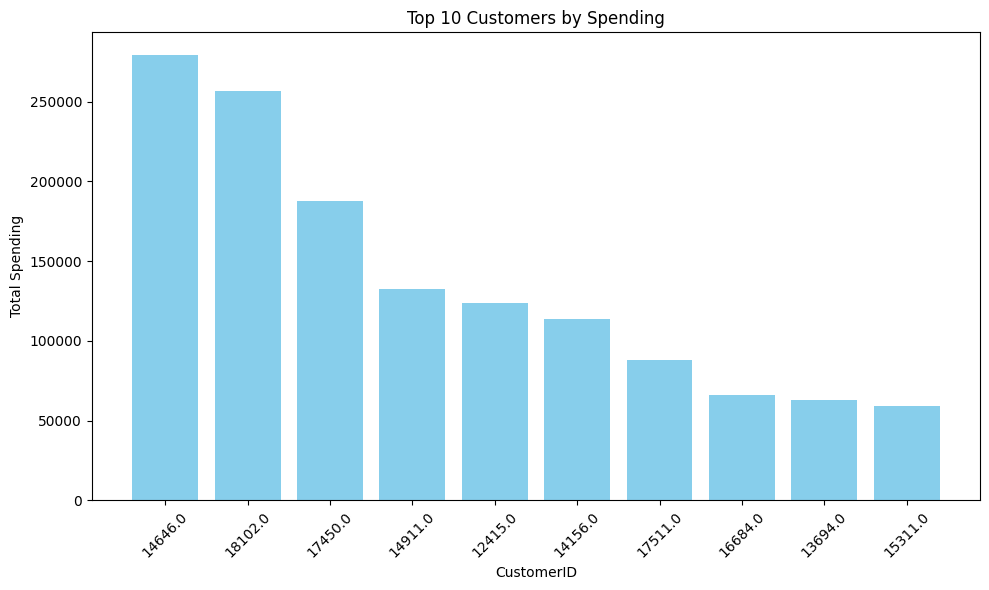

In [ ]:
# Data for top 10 customers and their spending
customers = [
    "14646.0", "18102.0", "17450.0", "14911.0", "12415.0",
    "14156.0", "17511.0", "16684.0", "13694.0", "15311.0"
]
spendings = [
    279489.02, 256438.49, 187482.17, 132572.62, 123725.45,
    113384.14, 88125.38, 65892.08, 62653.10, 59419.34
]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(customers, spendings, color='skyblue')
plt.xlabel("CustomerID")
plt.ylabel("Total Spending")
plt.title("Top 10 Customers by Spending")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Q2: Analyse Customer Behavior by Country
### First, we calculate the total spending for each transaction by multiplying the UnitPrice with Quantity. We then group the data by Country and aggregate the total spending and the number of orders per country. Additionally, we compute the average order size by dividing the total spending by the total number of orders for each country.

In [ ]:
def run_country_behavior_analysis(master_config):
    # Start Spark Session
    spark = SparkSession.builder.master(master_config).appName("Country Behavior Analysis").getOrCreate()
    print(f"Running with {master_config}")

    results = {}

    # Step 1: Data Loading
    start_time = time.time()
    data_path = "data.csv"
    df = spark.read.csv(data_path, header=True, inferSchema=True)
    results['data_loading'] = time.time() - start_time
    print(f"Data loading completed in {results['data_loading']:.2f} seconds")

    # Step 2: Preprocessing - Remove rows with null CustomerID
    start_time = time.time()
    df_cleaned = df.filter(col("CustomerID").isNotNull())
    results['data_preprocessing'] = time.time() - start_time
    print(f"Data preprocessing completed in {results['data_preprocessing']:.2f} seconds")

    # Step 3: Country-Level Behavior Analysis
    start_time = time.time()
    country_behavior_df = df_cleaned.withColumn("TotalSpending", col("UnitPrice") * col("Quantity")) \
        .groupBy("Country") \
        .agg(
            sum("TotalSpending").alias("TotalSpending"),
            count("InvoiceNo").alias("TotalOrders")
        ) \
        .withColumn("AverageOrderSize", col("TotalSpending") / col("TotalOrders")) \
        .sort(col("TotalSpending").desc())
    results['country_analysis'] = time.time() - start_time
    print(f"Country behavior analysis completed in {results['country_analysis']:.2f} seconds")

    # Step 4: Show Results for top 20 countries
    start_time = time.time()
    country_behavior_df.show(20, truncate=False)
    results['result_display'] = time.time() - start_time
    print(f"Result display completed in {results['result_display']:.2f} seconds")

    # Stop Spark Session
    spark.stop()

    return results

# Run the task for local[K] and local[*]
execution_results = {}
for config in ["local[2]", "local[4]", "local[*]"]:
    print(f"\n=== Running for {config} ===")
    execution_results[config] = run_country_behavior_analysis(config)

# Display Summary Results
print("\n=== Execution Summary ===")
for config, times in execution_results.items():
    print(f"Results for {config}:")
    for step, duration in times.items():
        print(f"  {step}: {duration:.2f} seconds")



=== Running for local[2] ===
Running with local[2]
Data loading completed in 3.61 seconds
Data preprocessing completed in 0.01 seconds
Country behavior analysis completed in 0.08 seconds
+---------------+------------------+-----------+------------------+
|Country        |TotalSpending     |TotalOrders|AverageOrderSize  |
+---------------+------------------+-----------+------------------+
|United Kingdom |6767873.394000085 |361878     |18.70208576923738 |
|Netherlands    |284661.539999999  |2371       |120.05969633066174|
|EIRE           |250285.21999999933|7485       |33.43823914495649 |
|Germany        |221698.21000000025|9495       |23.348942601369167|
|France         |196712.8400000004 |8491       |23.167217053350655|
|Australia      |137077.26999999987|1259       |108.87789515488473|
|Switzerland    |55739.40000000007 |1877       |29.69600426212044 |
|Spain          |54774.58000000016 |2533       |21.624390051322607|
|Belgium        |40910.960000000014|2069       |19.7733011116481

## Q3: Total Sales for Specific Time Period (Monthly)
### We extract the year and month from the Date column using year() and month(). Then, we group the data by these columns and sum the Amount to calculate total sales per each month. And lastly, we sort the results by Total_Sales in ascending order.

In [ ]:
def run_sales_analysis(master_config):
    # Start Spark Session
    spark = SparkSession.builder.master(master_config).appName("Sales Analysis").getOrCreate()
    print(f"Running with {master_config}")

    results = {}

    # Step 1: Data Loading
    start_time = time.time()
    data_path = "data.csv"
    df = spark.read.csv(data_path, header=True, inferSchema=True)
    results['data_loading'] = time.time() - start_time
    print(f"Data loading completed in {results['data_loading']:.2f} seconds")

    # Step 2: Preprocessing - Remove rows with null CustomerID
    start_time = time.time()
    df_cleaned = df.filter(col("CustomerID").isNotNull())
    results['data_preprocessing'] = time.time() - start_time
    print(f"Data preprocessing completed in {results['data_preprocessing']:.2f} seconds")

    # Step 3: Extract Year and Month from the Date column
    start_time = time.time()
    df_cleaned = df_cleaned.withColumn("Year", year(col("Date")))
    df_cleaned = df_cleaned.withColumn("Month", month(col("Date")))
    results['extract_year_month'] = time.time() - start_time
    print(f"Year and Month extraction completed in {results['extract_year_month']:.2f} seconds")

    # Step 4: Calculate total sales per month and year
    start_time = time.time()
    total_sales_per_month = df_cleaned.groupBy("Year", "Month").agg(sum("Amount").alias("Total_Sales"))
    results['calculate_total_sales'] = time.time() - start_time
    print(f"Total sales calculation completed in {results['calculate_total_sales']:.2f} seconds")

    # Step 5: Show the total sales per month and year
    start_time = time.time()
    total_sales_per_month.show()
    results['show_total_sales'] = time.time() - start_time
    print(f"Displaying total sales completed in {results['show_total_sales']:.2f} seconds")

    # Step 6: Sort the results by Total_Sales in descending order
    start_time = time.time()
    sorted_sales = total_sales_per_month.orderBy(col("Total_Sales").desc())
    results['sort_sales'] = time.time() - start_time
    print(f"Sorting total sales completed in {results['sort_sales']:.2f} seconds")

    # Step 7: Show the sorted results
    start_time = time.time()
    sorted_sales.show()
    results['show_sorted_sales'] = time.time() - start_time
    print(f"Displaying sorted sales completed in {results['show_sorted_sales']:.2f} seconds")

    # Stop Spark Session
    spark.stop()

    return results

# Run the task for local[K] and local[*]
execution_results = {}
for config in ["local[2]", "local[4]", "local[*]"]:
    print(f"\n=== Running for {config} ===")
    execution_results[config] = run_sales_analysis(config)

# Display Summary Results
print("\n=== Execution Summary ===")
for config, times in execution_results.items():
    print(f"Results for {config}:")
    for step, duration in times.items():
        print(f"  {step}: {duration:.2f} seconds")



=== Running for local[2] ===
Running with local[2]
Data loading completed in 3.06 seconds
Data preprocessing completed in 0.01 seconds
Year and Month extraction completed in 0.02 seconds
Total sales calculation completed in 0.02 seconds
+----+-----+------------------+
|Year|Month|       Total_Sales|
+----+-----+------------------+
|2010|   12|  554604.020000018|
|2011|    3| 579964.6100000151|
|2011|    2| 436546.1500000147|
|2011|    4| 426047.8510000125|
|2011|    8| 616368.0000000079|
|2011|    5|  648251.080000003|
|2011|    7|  574238.481000012|
|2011|    6| 608013.1600000106|
|2011|    1|475074.38000001636|
|2011|   12| 342506.3800000034|
|2011|   11|1132407.7399999578|
|2011|   10| 974603.5899999909|
|2011|    9| 931440.3719999959|
+----+-----+------------------+

Displaying total sales completed in 1.74 seconds
Sorting total sales completed in 0.01 seconds
+----+-----+------------------+
|Year|Month|       Total_Sales|
+----+-----+------------------+
|2011|   11|1132407.739999

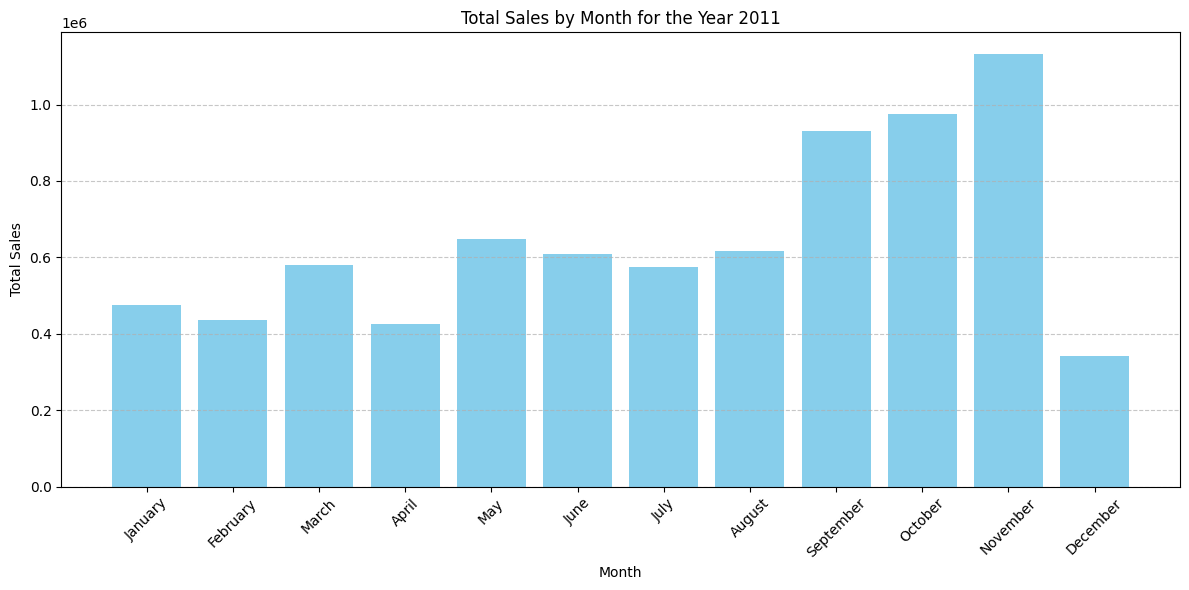

In [ ]:
# Data for the bar plot
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
total_sales = [
    475074.38, 436546.15, 579964.61, 426047.85, 648251.08,
    608013.16, 574238.48, 616368.00, 931440.37, 974603.59,
    1132407.74, 342506.38
]

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(months, total_sales, color='skyblue')

# Add labels, title, and grid
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Total Sales by Month for the Year 2011")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


## Q4: Top 10 Most Expensive Purchases
### We group the data by InvoiceNo and calculate the total sales for each invoice using the sum() function. We also retrieve the CustomerID and Country for each invoice using the first() function, as all rows for an invoice share the same values. Then, we sort the results by Total_Sales in descending order and limit the output to the top 10 invoices.

In [ ]:
def run_invoice_analysis(master_config):
    # Start Spark Session
    spark = SparkSession.builder.master(master_config).appName("Invoice Analysis").getOrCreate()
    print(f"Running with {master_config}")

    results = {}

    # Step 1: Data Loading
    start_time = time.time()
    data_path = "data.csv"
    df = spark.read.csv(data_path, header=True, inferSchema=True)
    results['data_loading'] = time.time() - start_time
    print(f"Data loading completed in {results['data_loading']:.2f} seconds")

    # Step 2: Preprocessing - Remove rows with null CustomerID
    start_time = time.time()
    df_cleaned = df.filter(col("CustomerID").isNotNull())
    results['data_preprocessing'] = time.time() - start_time
    print(f"Data preprocessing completed in {results['data_preprocessing']:.2f} seconds")

    # Step 3: Calculate total sales per InvoiceNo and retrieve CustomerID and Country
    start_time = time.time()
    total_sales_per_invoice = df_cleaned.groupBy("InvoiceNo") \
        .agg(
            sum("Amount").alias("Total_Sales"),
            first("CustomerID").alias("CustomerID"),
            first("Country").alias("Country")
        )
    results['calculate_total_sales_per_invoice'] = time.time() - start_time
    print(f"Total sales per invoice calculation completed in {results['calculate_total_sales_per_invoice']:.2f} seconds")

    # Step 4: Sort the results by Total_Sales in descending order and get the top 10 invoices
    start_time = time.time()
    top_10_expensive_invoices = total_sales_per_invoice.orderBy(col("Total_Sales").desc()).limit(10)
    results['sort_and_filter_top_10'] = time.time() - start_time
    print(f"Sorting and filtering top 10 invoices completed in {results['sort_and_filter_top_10']:.2f} seconds")

    # Step 5: Show the result
    start_time = time.time()
    top_10_expensive_invoices.show()
    results['show_results'] = time.time() - start_time
    print(f"Displaying results completed in {results['show_results']:.2f} seconds")

    # Stop Spark Session
    spark.stop()

    return results

# Run the task for local[K] and local[*]
execution_results = {}
for config in ["local[2]", "local[4]", "local[*]"]:
    print(f"\n=== Running for {config} ===")
    execution_results[config] = run_invoice_analysis(config)

# Display Summary Results
print("\n=== Execution Summary ===")
for config, times in execution_results.items():
    print(f"Results for {config}:")
    for step, duration in times.items():
        print(f"  {step}: {duration:.2f} seconds")



=== Running for local[2] ===
Running with local[2]
Data loading completed in 4.42 seconds
Data preprocessing completed in 0.01 seconds
Total sales per invoice calculation completed in 0.03 seconds
Sorting and filtering top 10 invoices completed in 0.01 seconds
+---------+------------------+----------+--------------+
|InvoiceNo|       Total_Sales|CustomerID|       Country|
+---------+------------------+----------+--------------+
|   581483|          168469.6|   16446.0|United Kingdom|
|   541431|           77183.6|   12346.0|United Kingdom|
|   556444|           38970.0|   15098.0|United Kingdom|
|   567423|31698.159999999996|   17450.0|United Kingdom|
|   556917|22775.930000000008|   12415.0|     Australia|
|   572209|           22206.0|   18102.0|United Kingdom|
|   567381|           22104.8|   17450.0|United Kingdom|
|   563614|21880.439999999995|   12415.0|     Australia|
|   550461|           21535.9|   15749.0|United Kingdom|
|   572035|          20277.92|   14646.0|   Netherland

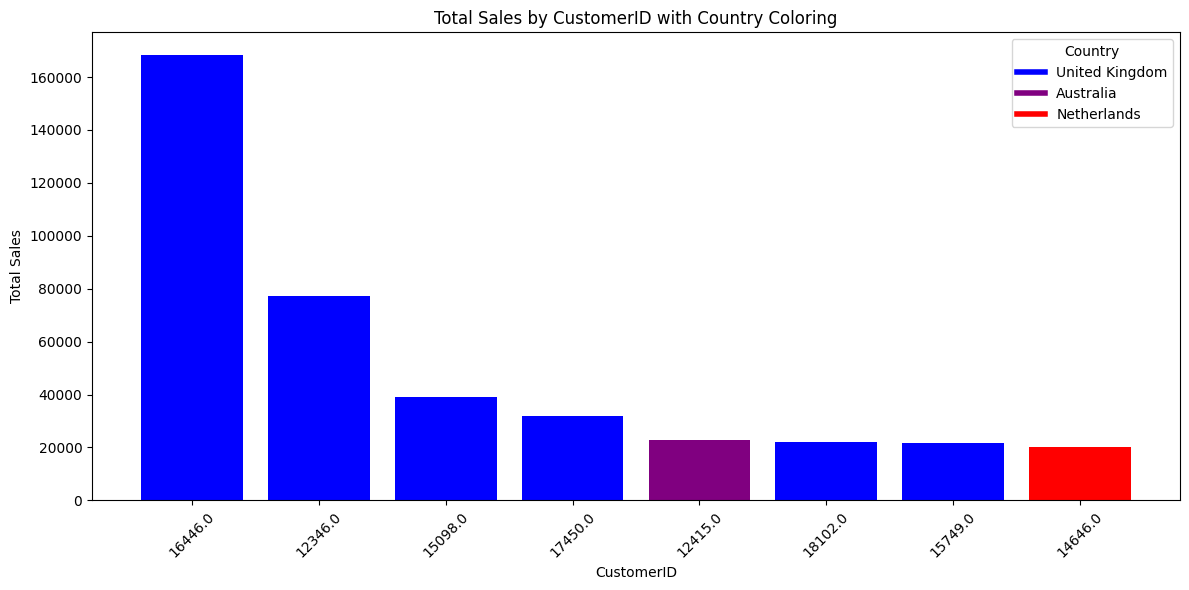

In [ ]:
# Data for the bar plot
customer_ids = ["16446.0", "12346.0", "15098.0", "17450.0", "12415.0",
                "18102.0", "17450.0", "12415.0", "15749.0", "14646.0"]
total_sales = [168469.6, 77183.6, 38970.0, 31698.16, 22775.93, 22206.0,
               22104.8, 21880.44, 21535.9, 20277.92]
countries = ["United Kingdom", "United Kingdom", "United Kingdom", "United Kingdom",
             "Australia", "United Kingdom", "United Kingdom", "Australia",
             "United Kingdom", "Netherlands"]

# Define color mapping for each country
color_mapping = {
    "United Kingdom": "blue",
    "Australia": "purple",
    "Netherlands": "red"
}
colors = [color_mapping[country] for country in countries]

# Create the bar plot
plt.figure(figsize=(12, 6))  # Increase figure size for better visibility
plt.bar(customer_ids, total_sales, color=colors)

# Add labels, title, and legend
plt.xlabel("CustomerID")
plt.ylabel("Total Sales")
plt.title("Total Sales by CustomerID with Country Coloring")
plt.xticks(rotation=45)  # Adjust rotation for better readability

# Add a legend for the colors
legend_labels = [plt.Line2D([0], [0], color=color, lw=4) for color in color_mapping.values()]
legend_names = list(color_mapping.keys())
plt.legend(legend_labels, legend_names, title="Country")

# Display the plot
plt.tight_layout()
plt.show()


## Q5: Predict Revenue For The next 30 Days:
### Here we implement a sales forecasting pipeline using PySpark. First, we aggregate total sales by date and calculate the number of days since the earliest date in the dataset. then, we prepare the data for regression by training a linear regression model to predict total sales. Finally, we predict the sales for the next 30 days based on the model we trained, using the latest date in the dataset as a reference.

In [ ]:
def run_sales_forecasting(master_config):
    # Start Spark Session
    spark = SparkSession.builder.master(master_config).appName("Sales Forecasting").getOrCreate()
    print(f"Running with {master_config}")

    results = {}

    # Step 1: Data Loading
    start_time = time.time()
    data_path = "data.csv"
    df = spark.read.csv(data_path, header=True, inferSchema=True)
    results['data_loading'] = time.time() - start_time
    print(f"Data loading completed in {results['data_loading']:.2f} seconds")

    # Step 2: Preprocessing - Remove rows with null CustomerID
    start_time = time.time()
    df_cleaned = df.filter(col("CustomerID").isNotNull())
    results['data_preprocessing'] = time.time() - start_time
    print(f"Data preprocessing completed in {results['data_preprocessing']:.2f} seconds")

    # Step 3: Aggregate sales by Date
    start_time = time.time()
    df_sales = df_cleaned.groupBy("Date").agg(sum("Amount").alias("Total_Sales"))
    results['aggregate_sales'] = time.time() - start_time
    print(f"Sales aggregation completed in {results['aggregate_sales']:.2f} seconds")

    # Step 4: Calculate days since the earliest date
    start_time = time.time()
    earliest_date = df_sales.select(min("Date")).collect()[0][0]
    latest_date = df_sales.select(max("Date")).collect()[0][0]
    df_sales = df_sales.withColumn(
        "Days_Since_Start",
        datediff(col("Date"), lit(earliest_date))
    )
    results['calculate_days_since_start'] = time.time() - start_time
    print(f"Calculating days since start completed in {results['calculate_days_since_start']:.2f} seconds")

    # Step 5: Assemble features for regression
    start_time = time.time()
    assembler = VectorAssembler(inputCols=["Days_Since_Start"], outputCol="features")
    df_sales = assembler.transform(df_sales)
    results['assemble_features'] = time.time() - start_time
    print(f"Feature assembling completed in {results['assemble_features']:.2f} seconds")

    # Step 6: Train Linear Regression Model
    start_time = time.time()
    lr = LinearRegression(featuresCol="features", labelCol="Total_Sales")
    lr_model = lr.fit(df_sales)
    results['train_model'] = time.time() - start_time
    print(f"Model training completed in {results['train_model']:.2f} seconds")

    # Step 7: Predict Sales for the next 30 days
    start_time = time.time()
    latest_days_since_start = (latest_date - earliest_date).days
    future_days_30 = [(latest_days_since_start + i,) for i in range(1, 31)]
    future_30_df = spark.createDataFrame(future_days_30, ["Days_Since_Start"])
    future_30_df = assembler.transform(future_30_df)
    predictions_30 = lr_model.transform(future_30_df)
    results['predict_sales'] = time.time() - start_time
    print(f"Sales prediction completed in {results['predict_sales']:.2f} seconds")

    # Step 8: Display Results
    start_time = time.time()
    predictions_30.select("Days_Since_Start", "prediction").show()
    results['display_results'] = time.time() - start_time
    print(f"Displaying results completed in {results['display_results']:.2f} seconds")

    # Stop Spark Session
    spark.stop()

    return results

# Run the task for local[K] and local[*]
execution_results = {}
for config in ["local[2]", "local[4]", "local[*]"]:
    print(f"\n=== Running for {config} ===")
    execution_results[config] = run_sales_forecasting(config)

# Display Summary Results
print("\n=== Execution Summary ===")
for config, times in execution_results.items():
    print(f"Results for {config}:")
    for step, duration in times.items():
        print(f"  {step}: {duration:.2f} seconds")



=== Running for local[2] ===
Running with local[2]
Data loading completed in 2.57 seconds
Data preprocessing completed in 0.01 seconds
Sales aggregation completed in 0.01 seconds
Calculating days since start completed in 2.93 seconds
Feature assembling completed in 0.04 seconds
Model training completed in 6.90 seconds
Sales prediction completed in 0.10 seconds
+----------------+------------------+
|Days_Since_Start|        prediction|
+----------------+------------------+
|             374| 37858.35900122734|
|             375| 37916.79553256957|
|             376|37975.232063911804|
|             377|38033.668595254036|
|             378| 38092.10512659627|
|             379|  38150.5416579385|
|             380| 38208.97818928073|
|             381| 38267.41472062296|
|             382|38325.851251965185|
|             383|38384.287783307416|
|             384| 38442.72431464965|
|             385| 38501.16084599188|
|             386| 38559.59737733411|
|             387| 38618.033

## Q6: Clustring datapoints based on Quantity, UnitPrice, and Amount features.
### now we perform clustring on sales data using the K-means algorithm in Pyspark. We Assembles selected features into a format suitable for clustering. Trains a K-Means model with 3 clusters. Measures execution times for each step across different Spark configurations (local[2], local[4], local[*]) and summarizes the results.

In [ ]:
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

def run_clustering(master_config):
    # Start Spark session
    spark = SparkSession.builder.master(master_config).appName("ClusteringSalesData").getOrCreate()
    print(f"Running with {master_config}")

    results = {}

    # Step 1: Load Data
    start_time = time.time()
    data_path = "data.csv"
    df = spark.read.csv(data_path, header=True, inferSchema=True, encoding='ISO-8859-1')
    results['data_loading'] = time.time() - start_time
    print(f"Data loading completed in {results['data_loading']:.2f} seconds")

    # Step 2: Preprocess Data
    start_time = time.time()
    selected_features = ["Quantity", "UnitPrice", "Amount"]
    df_cleaned = df.select(*selected_features).dropna()
    results['data_preprocessing'] = time.time() - start_time
    print(f"Data preprocessing completed in {results['data_preprocessing']:.2f} seconds")

    # Step 3: Assemble Features
    start_time = time.time()
    assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
    df_features = assembler.transform(df_cleaned)
    results['feature_assembling'] = time.time() - start_time
    print(f"Feature assembling completed in {results['feature_assembling']:.2f} seconds")

    # Step 4: Train KMeans Model
    start_time = time.time()
    kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=3, seed=42)
    kmeans_model = kmeans.fit(df_features)
    results['model_training'] = time.time() - start_time
    print(f"Model training completed in {results['model_training']:.2f} seconds")

    # Step 5: Cluster Data
    start_time = time.time()
    clustered_df = kmeans_model.transform(df_features)
    results['clustering'] = time.time() - start_time
    print(f"Clustering completed in {results['clustering']:.2f} seconds")

    # Step 6: Save Results
    start_time = time.time()
    output_path = f"clustering_results_{master_config.replace('[', '').replace(']', '')}.csv"
    clustered_df.select(*selected_features, "cluster").coalesce(1).write.csv(output_path, header=True, mode="overwrite")
    results['save_results'] = time.time() - start_time
    print(f"Saving results completed in {results['save_results']:.2f} seconds")

    # Stop Spark session
    spark.stop()

    return results

# Run clustering for multiple configurations
execution_results = {}
for config in ["local[2]", "local[4]", "local[*]"]:
    print(f"\n=== Running for {config} ===")
    execution_results[config] = run_clustering(config)

# Display Summary Results
print("\n=== Execution Summary ===")
for config, times in execution_results.items():
    print(f"Results for {config}:")
    for step, duration in times.items():
        print(f"  {step}: {duration:.2f} seconds")



=== Running for local[2] ===
Running with local[2]
Data loading completed in 2.48 seconds
Data preprocessing completed in 0.02 seconds
Feature assembling completed in 0.06 seconds
Model training completed in 12.90 seconds
Clustering completed in 0.07 seconds
Saving results completed in 3.27 seconds

=== Running for local[4] ===
Running with local[4]
Data loading completed in 3.67 seconds
Data preprocessing completed in 0.03 seconds
Feature assembling completed in 0.10 seconds
Model training completed in 13.50 seconds
Clustering completed in 0.10 seconds
Saving results completed in 4.04 seconds

=== Running for local[*] ===
Running with local[*]
Data loading completed in 2.49 seconds
Data preprocessing completed in 0.04 seconds
Feature assembling completed in 0.06 seconds
Model training completed in 13.72 seconds
Clustering completed in 0.11 seconds
Saving results completed in 2.64 seconds

=== Execution Summary ===
Results for local[2]:
  data_loading: 2.48 seconds
  data_preprocessin

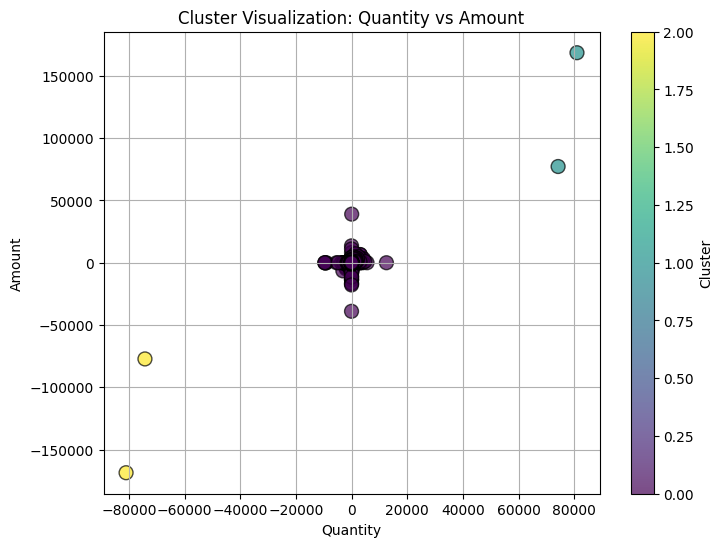

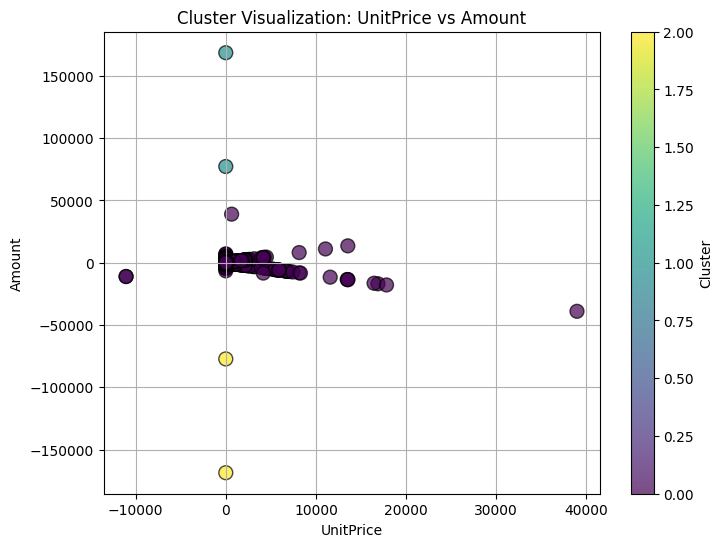

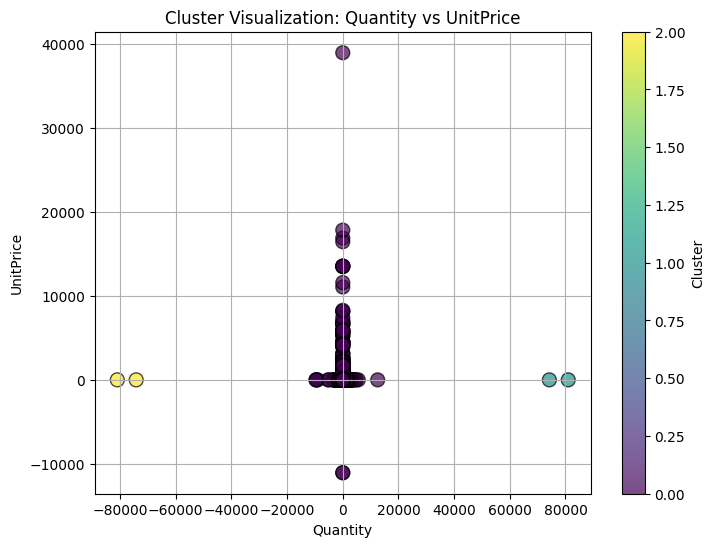

In [ ]:
# Load the saved clustering results from the CSV file
file_path = "res.csv"
df = pd.read_csv(file_path)

# Scatter plot for Quantity vs Amount, colored by cluster
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df["Quantity"],
    df["Amount"],
    c=df["cluster"],
    cmap="viridis",
    s=100,
    alpha=0.7,
    edgecolors="k",
)
plt.colorbar(scatter, label="Cluster")
plt.title("Cluster Visualization: Quantity vs Amount")
plt.xlabel("Quantity")
plt.ylabel("Amount")
plt.grid(True)
plt.show()

# Scatter plot for UnitPrice vs Amount, colored by cluster
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df["UnitPrice"],
    df["Amount"],
    c=df["cluster"],
    cmap="viridis",
    s=100,
    alpha=0.7,
    edgecolors="k",
)
plt.colorbar(scatter, label="Cluster")
plt.title("Cluster Visualization: UnitPrice vs Amount")
plt.xlabel("UnitPrice")
plt.ylabel("Amount")
plt.grid(True)
plt.show()

# Scatter plot for Quantity vs UnitPrice, colored by cluster
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df["Quantity"],
    df["UnitPrice"],
    c=df["cluster"],
    cmap="viridis",
    s=100,
    alpha=0.7,
    edgecolors="k",
)
plt.colorbar(scatter, label="Cluster")
plt.title("Cluster Visualization: Quantity vs UnitPrice")
plt.xlabel("Quantity")
plt.ylabel("UnitPrice")
plt.grid(True)
plt.show()
